# Modelo ARIMA no estacional
ver [1](https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html)
- ARMA(p,q)
- ARIMA(p,d,q)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA

from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
url = 'https://raw.githubusercontent.com/JASDataCTG/Diplomado-ML/main/Modulo%209/Datasets/pasajeros.csv'
df = pd.read_csv(url)
df.head()

,mes,pasajeros
0,2000-01-01,46492
1,2000-02-01,48526
2,2000-03-01,58764
3,2000-04-01,56033
4,2000-05-01,58201


- Conjunto de entrenamiento: 2000-01-01 to 2016-12-01
- Conjunto de validación: 2017-01-01 to 2019-12-01

In [4]:
df.dtypes

mes          object
pasajeros     int64
dtype: object

In [5]:
# Convertir a tipo fecha el campo mes
df['mes'] = pd.to_datetime(df['mes'])

# Dividir los datos en conjunto de entrenamiento y validación
fecha_corte = datetime.strptime('2016-12-01','%Y-%m-%d')
train_df = df[df['mes'] <= fecha_corte]
test_df = df[df['mes'] > fecha_corte]

# Convertir el campo mes en indice
train_df.set_index('mes',inplace=True) ## Indice es la fecha
test_df.set_index('mes',inplace=True)

In [6]:
train_df.tail()

,pasajeros
mes,
2016-08-01,73450
2016-09-01,66477
2016-10-01,69539
2016-11-01,66591
2016-12-01,67983


In [ ]:
test_df.head()

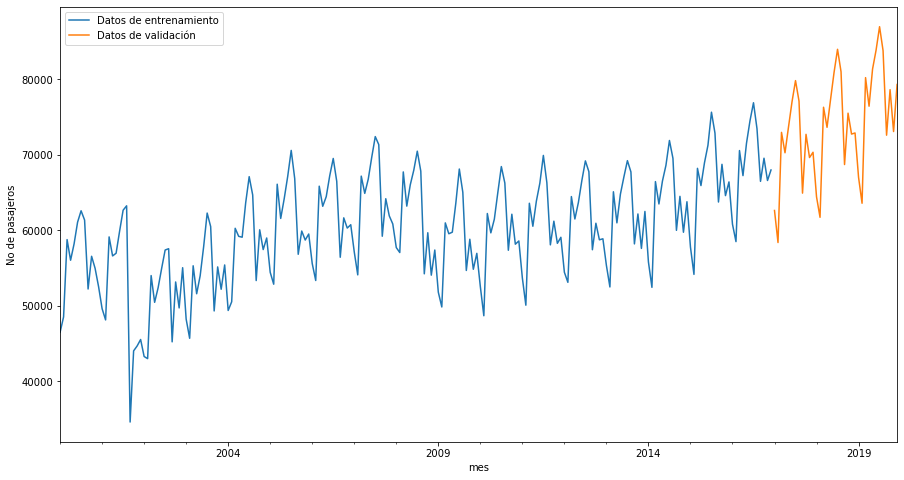

In [7]:
# visualize
fig,ax = plt.subplots(figsize=(15,8))
train_df.plot(kind='line',ax=ax)
test_df.plot(kind='line',ax=ax)
plt.xlabel('mes')
plt.ylabel('No de pasajeros')
plt.legend(['Datos de entrenamiento','Datos de validación'])
plt.show()

# Modelo ARMA (p,q)
**Steps for ARMA**
1. Aplicar el test Dickey-Fuller para la estacionalidad
2. Si es no estacionaria convertir a estacionaria
3. Encontrar los parámetros p, q
  - p : AR (pacf)
  - q : MA (acf)  (medias moviles)

4. Entrenar el modelo ARMA
5. Convertir de estacionario a no estacionario

### Paso-1: **Test de Dickey-Fuller**
- Nivel del error = 5%
  - p-value = 0.025

- Ho: La serie es no estacionarios (p-value >= 0.025) : bluk region
- HA: La serie es estacionaria (p-value < 0.025) : critical region

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
print(adfuller(train_df))
# EL SEGUNDO parametro que devuelve es el p-value, luego es no estacionaria

(-0.9529124941948435, 0.7700488660390643, 13, 190, {'1%': -3.4652439354133255, '5%': -2.8768752281673717, '10%': -2.574944653739612}, 3449.617955746232)


- p-value es mayor que 0.025, con una significancia del 5% existe evidencia estadística que la serie es no estacionaria.
- Se debe utilizar la diferencia para convertir la serie en estacionaria

### Paso-2: **Convertir la serie de no estacionaria a estacionaria**

In [10]:
stationary_train_df = train_df.diff()
# Borrar las instancias que contienen datos NaN
stationary_train_df.dropna(inplace=True)

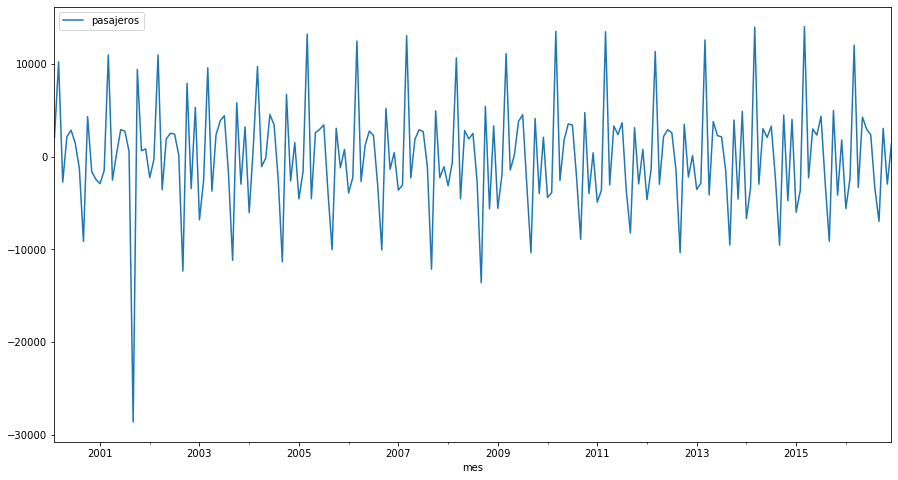

In [11]:
fig,ax = plt.subplots(figsize=(15,8))
stationary_train_df.plot(kind='line',ax=ax)

In [12]:
# Realizar de nuevo la prueba de Dickey-Fuller
print(adfuller(stationary_train_df))

(-3.770003898122402, 0.0032295638943137133, 12, 190, {'1%': -3.4652439354133255, '5%': -2.8768752281673717, '10%': -2.574944653739612}, 3430.804868488187)


- p-value = 0.0032 es menor que 0.025, entonces, el p-value esta en la región crítica de decisión por lo tanto hay evidencia estadística para rechazar la hipótesis nula y aceptar la alternativa (los datos son estacionarios)

### Paso-3: **Encontrar los parámetros p, q**

p : AR (pacf)

q : MA (acf)

> para encontrar el lag

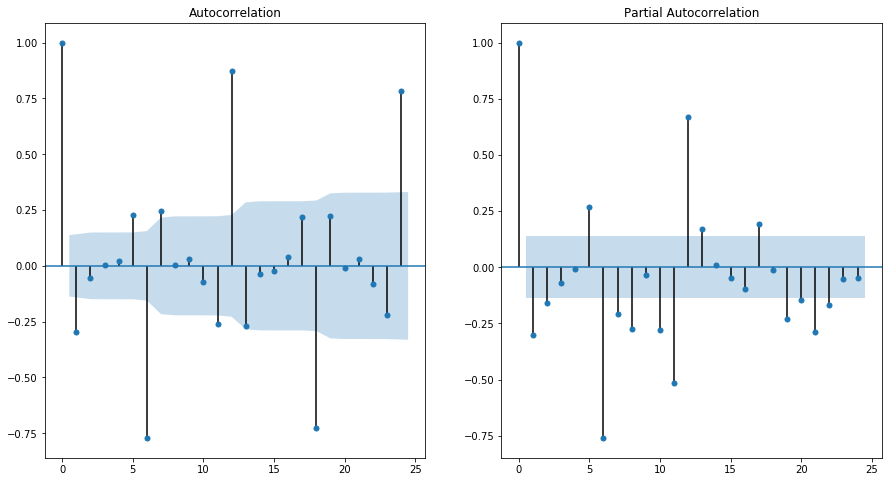

In [13]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

fig = plot_acf(stationary_train_df,ax=ax[0])
fig = plot_pacf(stationary_train_df,ax=ax[1])

p = 6 (parcial), q = 6 (auto)

### Paso-4: **Entrenar el modelo ARMA**

In [14]:
p,q = (6,6)
model_arma = ARMA(stationary_train_df,order=(p,q)).fit()

Evaluación del modelo

In [15]:
# Error
model_arma.aic

3767.8842787686754

In [16]:
from sklearn.metrics import mean_squared_error

In [17]:
y_train_pred = model_arma.fittedvalues

In [18]:
mse = mean_squared_error(stationary_train_df,y_train_pred)
print('mean square error =',mse)

mean square error = 6416799.708291508


### Gráfica

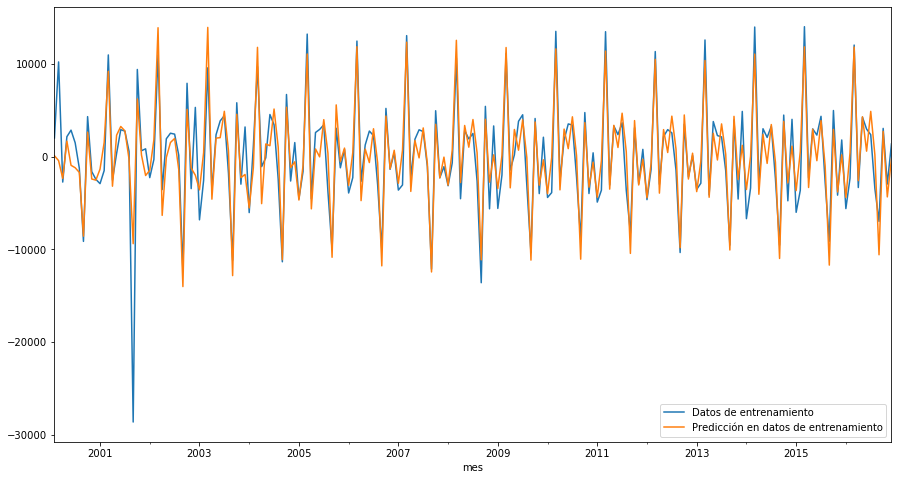

In [19]:
fig,ax = plt.subplots(figsize=(15,8))
stationary_train_df.plot(kind='line',ax=ax)
y_train_pred.plot(kind='line',ax=ax)
plt.legend(['Datos de entrenamiento','Predicción en datos de entrenamiento'])

In [20]:
start_date = datetime.strptime('2017-01-01','%Y-%m-%d')
end_date = datetime.strptime('2019-12-01','%Y-%m-%d')
prediction_values = model_arma.predict(start=start_date,end=end_date)

In [21]:
# Ver última fila
train_df.iloc[-1]

pasajeros    67983
Name: 2016-12-01 00:00:00, dtype: int64

In [22]:
# Convertir de estacionario a no estacionario
intial_value = 67983
y_test_pred = intial_value + prediction_values.cumsum()

In [23]:
# Cumsum realiza sumas acumuladas para convertir la serie en no estacionaria
a = np.array([1,2,3,4]) # se suma la acumulacion [1+1, 2+1+1, 3+2+1+1, 4+3+2+1+1]
b = 1 + a.cumsum()
b

array([ 2,  4,  7, 11])

In [ ]:
fig,ax = plt.subplots(figsize=(15,8))
train_df.plot(kind='line',ax=ax,alpha=0.5)
test_df.plot(kind='line',ax=ax,alpha=0.5)

y_test_pred.plot(kind='line',ax=ax)
plt.xlabel('Mes')
plt.ylabel('No de pasajeros')
plt.legend(['Datos de entrenamiento','Datos de validación','Predicción'])
plt.show()

## ARIMA(p,d,q)
- (6,0,6)

In [24]:
model_arima = ARIMA(stationary_train_df,order=(6,0,6)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24574D+00    |proj g|=  6.53680D-01

At iterate    5    f=  9.23769D+00    |proj g|=  5.24959D-01

At iterate   10    f=  9.23239D+00    |proj g|=  1.95957D-01

At iterate   15    f=  9.23198D+00    |proj g|=  1.78771D-01

At iterate   20    f=  9.23095D+00    |proj g|=  3.93732D-01

At iterate   25    f=  9.23050D+00    |proj g|=  1.57741D-01

At iterate   30    f=  9.23048D+00    |proj g|=  5.65368D-02

At iterate   35    f=  9.23046D+00    |proj g|=  7.60364D-02

At iterate   40    f=  9.23041D+00    |proj g|=  1.31933D-01

At iterate   45    f=  9.23035D+00    |proj g|=  1.15602D-01

At iterate   50    f=  9.23032D+00    |proj g|=  9.08562D-02

At iterate   55    f=  9.23027D+00    |proj g|=  3.30232D-02

At iterate   60    f=  9.23019D+00    |proj g|=  1.25585D-01

At iterate   65    f=  9.2

In [25]:
start_date = datetime.strptime('2017-01-01','%Y-%m-%d')
end_date = datetime.strptime('2019-12-01','%Y-%m-%d')
predicted_value_arima = model_arima.predict(start=start_date,end=end_date)

In [26]:
train_df.iloc[-1] ## ultimo valor 

pasajeros    67983
Name: 2016-12-01 00:00:00, dtype: int64

In [28]:
y_test_pred_arima = 67983 + np.cumsum(predicted_value_arima) # serie estacionaria

In [29]:
len(y_test_pred_arima)

36

In [30]:
# Intervalo de confianza
intervalo_confianza = model_arima.forecast(steps=36)[-1]

In [31]:
model_arima.forecast(steps=36)[-1] #ultimo valor

array([[ -9696.50768741,   -898.04544704],
       [ -5570.37852112,   3338.50034514],
       [  5704.4948899 ,  14690.87455513],
       [ -7574.48997617,   1448.8241787 ],
       [  -263.79767901,   8833.19696437],
       [ -4181.07041078,   5014.73462047],
       [  1057.38384033,  10253.19796825],
       [ -3164.03232424,   6125.00204041],
       [-14435.70708943,  -5080.32560875],
       [ -1297.51701317,   8090.3955742 ],
       [ -8765.57422696,    693.02979233],
       [ -4942.17942553,   4616.97904217],
       [-10359.30427679,   -799.76570582],
       [ -6232.36865544,   3405.8725532 ],
       [  4897.45731373,  14592.33665996],
       [ -8170.07733101,   1553.27279716],
       [  -691.62384796,   9099.3647839 ],
       [ -4624.58548492,   5268.35325163],
       [   968.98656563,  10863.11686342],
       [ -3220.29552288,   6740.20568846],
       [-14317.22466676,  -4308.57496705],
       [ -1372.72020789,   8660.65167645],
       [ -8991.22018655,   1106.66170896],
       [ -5

In [33]:
lim_sup = y_test_pred_arima + intervalo_confianza[:,1]
lim_inf = y_test_pred_arima + intervalo_confianza[:,0]

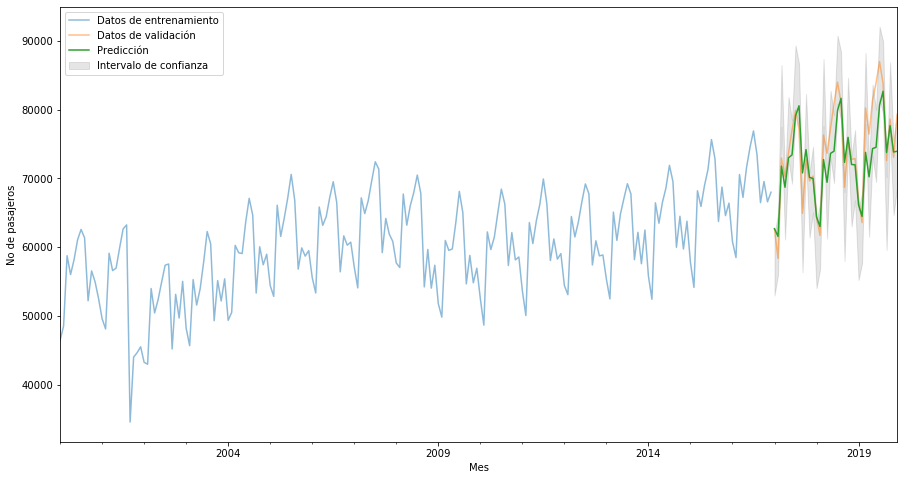

In [34]:
# visualize
fig,ax = plt.subplots(figsize=(15,8))
train_df.plot(kind='line',ax=ax,alpha=0.5)
test_df.plot(kind='line',ax=ax,alpha=0.5)


y_test_pred_arima.plot(kind='line',ax=ax)
plt.fill_between(test_df.index,lim_inf,lim_sup,color='k',alpha=0.1)

plt.xlabel('Mes')
plt.ylabel('No de pasajeros')
plt.legend(['Datos de entrenamiento','Datos de validación','Predicción','Intervalo de confianza'])
plt.show()

# Auto Arima

Este es el que generalmente se hace, y ajusta con diferentes parámetros

Ajusta varios modelos y escoje el mejor

In [ ]:
#!pip install pmdarima

In [35]:
from pmdarima import auto_arima

In [36]:
auto_model = auto_arima(stationary_train_df,start_p=12, d=0, start_q=6, max_p=24, max_d=2, max_q=24,
                        seasonal=False,stationary=True,trace=True,scoring ='mse')

Performing stepwise search to minimize aic
 ARIMA(12,0,6)(0,0,0)[0] intercept   : AIC=3758.330, Time=3.68 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4100.940, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4084.137, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4078.462, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4099.007, Time=0.01 sec
 ARIMA(11,0,6)(0,0,0)[0] intercept   : AIC=inf, Time=3.19 sec
 ARIMA(12,0,5)(0,0,0)[0] intercept   : AIC=3765.289, Time=3.29 sec
 ARIMA(13,0,6)(0,0,0)[0] intercept   : AIC=3759.911, Time=4.22 sec
 ARIMA(12,0,7)(0,0,0)[0] intercept   : AIC=3751.737, Time=4.34 sec
 ARIMA(11,0,7)(0,0,0)[0] intercept   : AIC=3739.164, Time=4.22 sec
 ARIMA(10,0,7)(0,0,0)[0] intercept   : AIC=3753.029, Time=3.62 sec
 ARIMA(11,0,8)(0,0,0)[0] intercept   : AIC=inf, Time=3.99 sec
 ARIMA(10,0,6)(0,0,0)[0] intercept   : AIC=inf, Time=3.11 sec
 ARIMA(10,0,8)(0,0,0)[0] intercept   : AIC=inf, Time=3.44 sec
 ARIMA(12,0,8)(0,0,0)[0] intercept   : AIC=

In [37]:
model_arima_best = ARIMA(stationary_train_df,(11,0,7)).fit()
#

In [38]:
# Realizar la predicción
start_date = datetime.strptime('2017-01-01','%Y-%m-%d')
end_date = datetime.strptime('2019-12-01','%Y-%m-%d')
prediction_arima_best = model_arima_best.predict(start_date,end_date)

In [39]:
train_df.iloc[-1]

pasajeros    67983
Name: 2016-12-01 00:00:00, dtype: int64

In [40]:
forecasted_values_arima_best = 67983 + np.cumsum(prediction_arima_best)# convierte a estacionario!

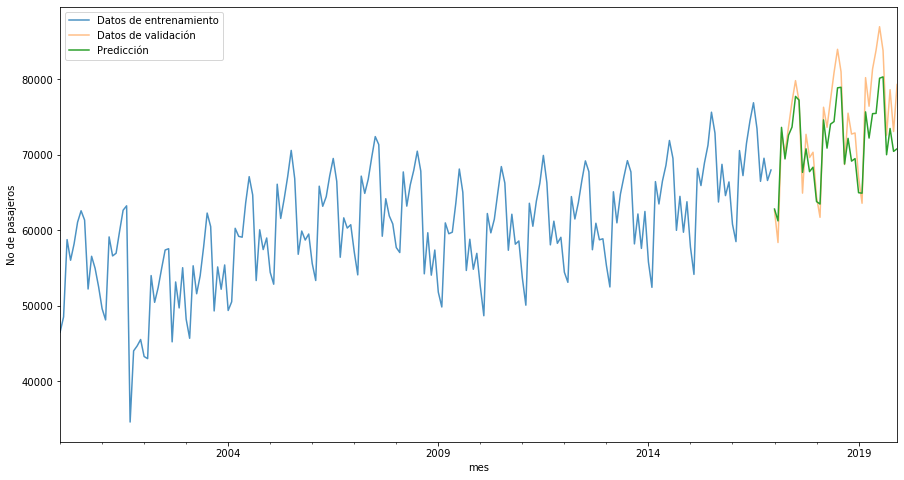

In [41]:
fig,ax = plt.subplots(figsize=(15,8))
train_df.plot(kind='line',ax=ax,alpha=0.8)
test_df.plot(kind='line',ax=ax,alpha=0.5)

forecasted_values_arima_best.plot(kind='line',ax=ax)
plt.ylabel('No de pasajeros')
plt.legend(['Datos de entrenamiento','Datos de validación','Predicción'])
plt.show()